In [1]:
# !pip3 install tensorflow

In [2]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from matplotlib import pyplot as plt

2023-08-13 10:54:14.045503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Initialise data

In [3]:
# setup general info on batch sizes and img sizes
batch_size = 32
img_height = 180
img_width = 180

In [4]:
# taken from tf tutorial, unknown what this does so far
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
datadir = os.path.join('..', 'Data', 'Cars')

In [6]:
# generate training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    datadir,
    validation_split= 0.2, # let the program know what the validation split will be in order to choose the correct size of this training set as well
    subset="training", # here we denote that this set will be the *training* set.
    seed=123,
    image_size = (img_height, img_width), # rescale images automatically
    batch_size= batch_size
) 

# randomly shuffle your data.
train_ds_pref = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# automatic labelling with this object, based on dict names.
class_names = train_ds.class_names

Found 3697 files belonging to 5 classes.
Using 2958 files for training.


In [7]:
# generate validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    datadir,
    validation_split= 0.2,
    subset="validation", # here we denote that this set will be the *validation* set.
    seed=123, 
    image_size = (img_height, img_width),
    batch_size= batch_size
)

# function of this line is currently unknown.
val_ds_pref = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3697 files belonging to 5 classes.
Using 739 files for validation.


## Data augmentation

In [8]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Train the model

In [10]:
from tensorflow.keras.layers import Dropout

In [11]:
# num_classes = len(class_names)

# model = Sequential([
#   data_augmentation, # data augmentation as a very first step
#   layers.Rescaling(1./255),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   # layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2), # here we perform the dropout.
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs")
# ])

In [12]:
pre_trained = tf.keras.applications.vgg16.VGG16(input_shape = (180,180,3), include_top=False, weights='imagenet')

In [13]:
for layer in pre_trained.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [14]:
last_layer = pre_trained.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation= 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(5, activation = 'softmax')(x)


In [15]:
model = tf.keras.Model(pre_trained.input, x)

In [16]:
# compile the model
model.compile(optimizer='adam', # choose the optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function is same as error function
              metrics=['accuracy']) # choose which metrics to keep track of during optimization

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [22]:
epochs = 15
history = model.fit(
  train_ds_pref,
  validation_data=val_ds_pref,
  epochs=epochs
)

Epoch 1/15
93/93 [==============================] - 359s 4s/step - loss: 0.7862 - accuracy: 0.6846 - val_loss: 0.9905 - val_accuracy: 0.6401
Epoch 2/15
93/93 [==============================] - 364s 4s/step - loss: 0.7204 - accuracy: 0.7011 - val_loss: 0.9766 - val_accuracy: 0.6482
Epoch 3/15
93/93 [==============================] - 364s 4s/step - loss: 0.6859 - accuracy: 0.7211 - val_loss: 1.0401 - val_accuracy: 0.6333
Epoch 4/15
93/93 [==============================] - 364s 4s/step - loss: 0.6753 - accuracy: 0.7238 - val_loss: 0.9303 - val_accuracy: 0.6806
Epoch 5/15
93/93 [==============================] - 364s 4s/step - loss: 0.6691 - accuracy: 0.7404 - val_loss: 1.0628 - val_accuracy: 0.6482
Epoch 6/15
93/93 [==============================] - 357s 4s/step - loss: 0.7091 - accuracy: 0.7292 - val_loss: 1.0307 - val_accuracy: 0.6306
Epoch 7/15
93/93 [==============================] - 341s 4s/step - loss: 0.6448 - accuracy: 0.7387 - val_loss: 0.9589 - val_accuracy: 0.6536
Epoch 8/15
42

KeyboardInterrupt: 

In [21]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

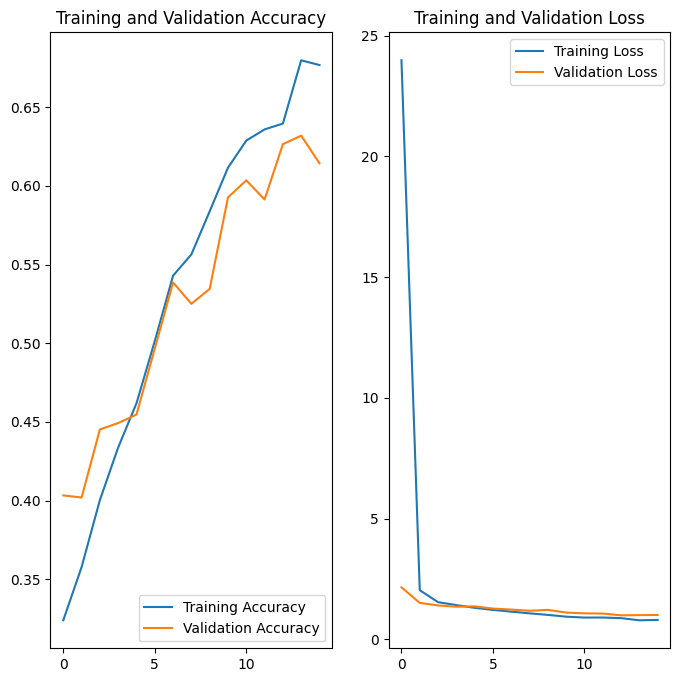

In [20]:
# plot the training results
plot_results(history)